## **IMPORTING DATA**

In [1]:
!mkdir ~/.kaggle

In [2]:
!cp kaggle.json ~/.kaggle/

In [3]:
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d sovitrath/diabetic-retinopathy-224x224-gaussian-filtered

 96% 410M/427M [00:02<00:00, 142MB/s]
100% 427M/427M [00:02<00:00, 158MB/s]


In [5]:
!unzip '/content/diabetic-retinopathy-224x224-gaussian-filtered.zip'

Archive:  /content/diabetic-retinopathy-224x224-gaussian-filtered.zip
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/0024cdab0c1e.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/00cb6555d108.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/0124dffecf29.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/01b3aed3ed4c.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/0369f3efe69b.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/03e25101e8e8.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/04ac765f91a1.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/059bc89df7f4.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/05a5183c92d0.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/0684311afdfc.png  
  inflating: gaussian_filtered_images/gaussian_filtered_imag

## **DATA PREPROCESSING**

In [6]:
import numpy as np
import pandas as pd
import random, os

In [7]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy, AUC
from sklearn.model_selection import train_test_split

In [8]:
!pip install tensorflow_addons

     |████████████████████████████████| 679 kB 9.6 MB/s 


In [9]:
import tensorflow_addons
from tensorflow_addons.metrics import F1Score, CohenKappa

In [10]:
df = pd.read_csv('/content/train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}

In [11]:
df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


### **MULTI CLASS IMBALANCE PROBLEM**

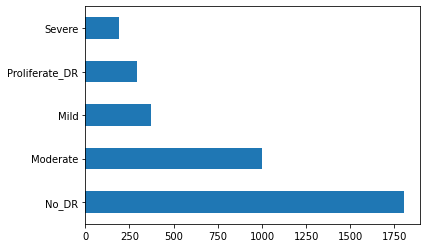

In [ ]:
df['type'].value_counts().plot(kind='barh')

## **BINARY CLASS AND BALANCED DATA**

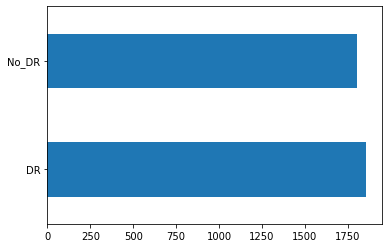

In [ ]:
df['binary_type'].value_counts().plot(kind='barh')

## **DATA TRANSFORMATION**

In [13]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size = 0.2, stratify = df['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')

No_DR             1444
Moderate           799
Mild               296
Proliferate_DR     236
Severe             154
Name: type, dtype: int64 

No_DR             361
Moderate          200
Mild               74
Proliferate_DR     59
Severe             39
Name: type, dtype: int64 



In [14]:
import shutil
base_dir = '/content/New_DR'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [15]:
src_dir = '/content/gaussian_filtered_images/gaussian_filtered_images'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

### **Visualization of DR and Non-DR Images**

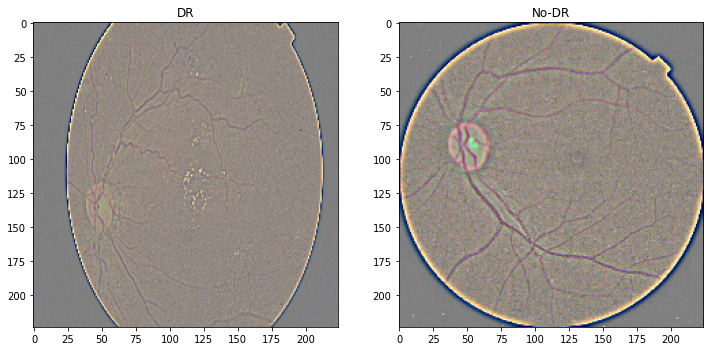

In [52]:
from PIL import Image 

f = plt.figure(figsize=(12,6))
# creating a object 
im1 = Image.open(r"/content/New_DR/train/DR/00a8624548a9.png") 
im2 = Image.open(r"/content/New_DR/train/No_DR/02da652c74b8.png") 


f.add_subplot(1,2, 1)
plt.title('DR')
plt.imshow(im1)
f.add_subplot(1,2, 2)
plt.title('No-DR')
plt.imshow(im2)
plt.show(block=True)

## **DATA AUGMENTATION**

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import pandas as pd 
%matplotlib inline
import tensorflow as tf
import keras
import glob

In [53]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(rescale = 1./255)

test_no_dr_path = glob.glob("/content/New_DR/test/No_DR")
test_no_dr_label = test_no_dr_path[0].split("/")[-1]
for image_path in glob.glob(os.path.join(test_no_dr_path[0], "*.png")):
    img = load_img(image_path)  # this is a PIL image
    x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
    x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

        # the .flow() command below generates batches of randomly transformed images
        # and saves the results to the preview/ directory
    i = 0
    for batch in datagen.flow(x, batch_size=1,save_to_dir=(os.path.join("/content/New_DR/test/",test_no_dr_label))+'/', save_prefix=test_no_dr_label, save_format='png'):
        i += 1
        if i > 5:
            break  # otherwise the generator would loop indefinitely

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(rescale = 1./255)

test_dr_path = glob.glob("/content/New_DR/test/DR")
test_dr_label = test_dr_path[0].split("/")[-1]
for image_path in glob.glob(os.path.join(test_dr_path[0], "*.png")):
    img = load_img(image_path)  # this is a PIL image
    x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
    x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

        # the .flow() command below generates batches of randomly transformed images
        # and saves the results to the preview/ directory
    i = 0
    for batch in datagen.flow(x, batch_size=1,save_to_dir=(os.path.join("/content/New_DR/test/",test_dr_label))+'/', save_prefix=test_dr_label, save_format='png'):
        i += 1
        if i > 5:
            break  # otherwise the generator would loop indefinitely

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(rescale = 1./255,shear_range = 0.1,zoom_range = 0.1,horizontal_flip = True)

train_dr_path = glob.glob("/content/New_DR/train/DR")
train_dr_label = train_dr_path[0].split("/")[-1]
for image_path in glob.glob(os.path.join(train_dr_path[0], "*.png")):
    img = load_img(image_path)  # this is a PIL image
    x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
    x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

        # the .flow() command below generates batches of randomly transformed images
        # and saves the results to the preview/ directory
    i = 0
    for batch in datagen.flow(x, batch_size=1,save_to_dir=(os.path.join("/content/New_DR/train/",train_dr_label))+'/', save_prefix=train_dr_label, save_format='png'):
        i += 1
        if i > 5:
            break  # otherwise the generator would loop indefinitely

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(rescale = 1./255,shear_range = 0.1,zoom_range = 0.1,horizontal_flip = True)

train_no_dr_path = glob.glob("/content/New_DR/train/No_DR")
train_no_dr_label = train_no_dr_path[0].split("/")[-1]
for image_path in glob.glob(os.path.join(train_no_dr_path[0], "*.png")):
    img = load_img(image_path)  # this is a PIL image
    x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
    x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

        # the .flow() command below generates batches of randomly transformed images
        # and saves the results to the preview/ directory
    i = 0
    for batch in datagen.flow(x, batch_size=1,save_to_dir=(os.path.join("/content/New_DR/train/",train_no_dr_label))+'/', save_prefix=train_no_dr_label, save_format='png'):
        i += 1
        if i > 5:
            break  # otherwise the generator would loop indefinitely

## **INPUT DATA PREPARATION AND FEATURE EXTRACTION USING VGG16**

In [17]:
import string
import numpy as np
from PIL import Image
import os 
import pickle
import pandas as pd
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Conv2D, MaxPooling2D, Flatten, Add
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import add
#from torchvision import datasets, transforms, models
import cv2
import multiprocessing as mp
from tensorflow import keras 
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras import regularizers

In [18]:
# defining a function for feature extraction using VGG16
def extract_features1(imageList):
    model =  VGG16(weights='imagenet', include_top=False, pooling = 'avg')
    features = list()
    for img in imageList:
        image = Image.fromarray(img, 'RGB')
        image = image.resize((224,224))
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        feature = model.predict(image)
        features.append(feature)
    features = np.array(features)
    features = features.reshape((len(imageList), 512))
    return features 

In [19]:
import cv2
import glob
import numpy as np

X_data = []
files = glob.glob ("/content/New_DR/test/DR/*.png")
for myFile in files:
    # print(myFile)
    image = cv2.imread (myFile)
    X_data.append (image)

print('X_data Len:', len(X_data))

X_data_new = extract_features1(X_data) 
X_data_new.shape

X_data Len: 372
58892288/58889256 [==============================] - 0s 0us/step


(372, 512)

In [20]:
import cv2
import glob
import numpy as np

X_data = []
files = glob.glob ("/content/New_DR/test/No_DR/*.png")
for myFile in files:
    # print(myFile)
    image = cv2.imread (myFile)
    X_data.append (image)

print('X_data Len:', len(X_data))

X_data_new_no = extract_features1(X_data)
X_data_new_no.shape

X_data Len: 361


(361, 512)

In [21]:
import cv2
import glob
import numpy as np

X_data = []
files = glob.glob ("/content/New_DR/train/No_DR/*.png")
for myFile in files:
    # print(myFile)
    image = cv2.imread (myFile)
    X_data.append (image)

print('X_data Len:', len(X_data))

X_train_data_new_no = extract_features1(X_data)
X_train_data_new_no.shape 

X_data Len: 1444


(1444, 512)

In [22]:
import cv2
import glob
import numpy as np

X_data = []
files = glob.glob ("/content/New_DR/train/DR/*.png")
for myFile in files:
    # print(myFile)
    image = cv2.imread (myFile)
    X_data.append (image)

print('X_data Len:', len(X_data))

X_train_data_new = extract_features1(X_data)
X_train_data_new.shape 

X_data Len: 1485


(1485, 512)

In [23]:
print(X_data_new.shape)
print(X_data_new_no.shape)
print(X_train_data_new.shape)
print(X_train_data_new_no.shape) 

(372, 512)
(361, 512)
(1485, 512)
(1444, 512)


In [24]:
y_data_new = np.full(shape=X_data_new.shape[0],
  fill_value=1,
  dtype=np.int
)
y_data_new_no = np.full(shape=X_data_new_no.shape[0],
  fill_value=0,
  dtype=np.int
)
y_train_data_new = np.full(shape=X_train_data_new.shape[0],
  fill_value=1,
  dtype=np.int
)
y_train_data_new_no = np.full(shape=X_train_data_new_no.shape[0],
  fill_value=0,
  dtype=np.int
)

In [25]:
X_test_numeric = np.concatenate((X_data_new, X_data_new_no))
X_test_numeric.shape

(733, 512)

In [26]:
X_train_numeric = np.concatenate((X_train_data_new, X_train_data_new_no))
X_train_numeric.shape

(2929, 512)

In [27]:
y_test = np.concatenate((y_data_new, y_data_new_no))
y_test.shape

(733,)

In [28]:
y_train = np.concatenate((y_train_data_new, y_train_data_new_no))
y_train.shape

(2929,)

## **INPUT DATA PREPARATION FOR CNN MODEL**

In [29]:
import cv2
import glob
import numpy as np

X_test_no_dr_CNN = []
files = glob.glob ("/content/New_DR/test/No_DR/*.png")
for myFile in files:
    # print(myFile)
    image = cv2.imread (myFile)
    X_test_no_dr_CNN.append (image)

print('X_data Len:', len(X_test_no_dr_CNN))

X_data Len: 361


In [30]:
import cv2
import glob
import numpy as np

X_test_dr_CNN = []
files = glob.glob ("/content/New_DR/test/DR/*.png")
for myFile in files:
    # print(myFile)
    image = cv2.imread (myFile)
    X_test_dr_CNN.append (image)

print('X_data Len:', len(X_test_dr_CNN))

X_data Len: 372


In [31]:
import cv2
import glob
import numpy as np

X_train_no_dr_CNN = []
files = glob.glob ("/content/New_DR/train/No_DR/*.png")
for myFile in files:
    # print(myFile)
    image = cv2.imread (myFile)
    X_train_no_dr_CNN.append (image)

print('X_data Len:', len(X_train_no_dr_CNN))

X_data Len: 1444


In [32]:
import cv2
import glob
import numpy as np

X_train_dr_CNN = []
files = glob.glob ("/content/New_DR/train/DR/*.png")
for myFile in files:
    # print(myFile)
    image = cv2.imread (myFile)
    X_train_dr_CNN.append (image)

print('X_data Len:', len(X_train_dr_CNN))

X_data Len: 1485


In [33]:
X_test_no_dr_CNN_final = np.array(X_test_no_dr_CNN)
X_test_dr_CNN_final = np.array(X_test_dr_CNN)
X_train_no_dr_CNN_final = np.array(X_train_no_dr_CNN)
X_train_dr_CNN_final = np.array(X_train_dr_CNN)

X_test_no_dr_CNN_final.shape, X_test_dr_CNN_final.shape, X_train_no_dr_CNN_final.shape, X_train_dr_CNN_final.shape

((361, 224, 224, 3),
 (372, 224, 224, 3),
 (1444, 224, 224, 3),
 (1485, 224, 224, 3))

In [34]:
X_test_image = np.concatenate((X_test_dr_CNN_final, X_test_no_dr_CNN_final))
X_test_image.shape

(733, 224, 224, 3)

In [35]:
X_train_image = np.concatenate((X_train_dr_CNN_final, X_train_no_dr_CNN_final))
X_train_image.shape

(2929, 224, 224, 3)

## **KERAS TUNER FOR CNN**

In [ ]:
!pip install keras_tuner

     |████████████████████████████████| 96 kB 4.4 MB/s 


In [ ]:
import keras_tuner as kt
def build_model(hp):
  model = tf.keras.Sequential([
      layers.Conv2D(hp.Choice('units', [32, 64]), (3,3), padding="same", input_shape=(224,224,3), activation = 'relu'),
      layers.MaxPooling2D(pool_size=(2,2)),

      layers.Conv2D(hp.Choice('units', [64, 128]), (3,3), padding="same", activation = 'relu'),
      layers.MaxPooling2D(pool_size=(2,2)),
      layers.Dropout(0.25),

      layers.Conv2D(hp.Choice('units', [128, 256]), (3,3), padding="same", activation = 'relu'),
      layers.MaxPooling2D(pool_size=(2,2)),

      layers.Conv2D(hp.Choice('units', [128, 256]), (3,3), padding="same", activation = 'relu'),
      layers.MaxPooling2D(pool_size=(2,2)),
      layers.Dropout(0.25),

      layers.Flatten(),
       layers.Dropout(0.30),
      layers.Dense(hp.Choice('units', [256, 512]), activation = 'relu'),
      layers.Dense(1, activation = 'sigmoid')
  ])
  lr = 1e-3
  opt = Adam(learning_rate=lr)
  model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
  #model.summary()
  return model

In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json


In [ ]:
tuner.search(np.array(X_train_image), np.array(y_train), epochs=20, validation_data=(X_test_image, y_test))
best_model_1 = tuner.get_best_models()[0]

Trial 2 Complete [00h 02m 46s]
val_loss: 0.6930348873138428

Best val_loss So Far: 0.17199744284152985
Total elapsed time: 00h 08m 08s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0

## **DUAL CHANNEL-CNN ARCHITECTURE**

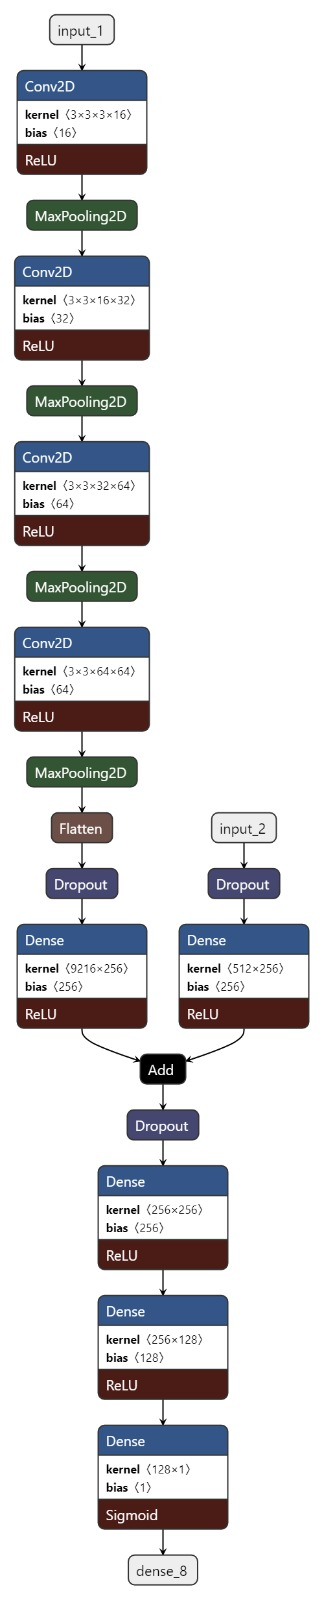

## **DATA MODELING FOR DUAL CHANNEL CNN**

In [36]:
def create_ff(dim, regress=False):
	# define our FF network
	model = Sequential()
	model.add(Dropout(0.5, input_dim=dim))
	model.add(Dense(256, activation='relu'))
	# check to see if the regression node should be added
	if regress:
		model.add(Dense(1, activation="linear"))
	# return our model
	return model 

In [37]:
def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
  inputShape = (height, width, depth)
  chanDim = -1
	# define the model input
  inputs = Input(shape=inputShape)
  layer1 = Conv2D(32, (3,3), activation='relu')(inputs)
  layer2 = MaxPooling2D((2,2))(layer1)
  layer21 = Dropout((0.25))(layer2)
  layer3 = Conv2D(64, (5,5), activation='relu')(layer21)
  layer4 = MaxPooling2D((2,2))(layer3)
  layer41 = Dropout((0.25))(layer4)
  layer5 = Conv2D(128, (5,5), activation='relu')(layer41)
  layer6 = MaxPooling2D((2,2))(layer5)
  layer61 = Dropout((0.25))(layer6)
  layer7 = Conv2D(128, (3,3), activation='relu')(layer61)
  layer8 = MaxPooling2D((2,2))(layer7)
  layer81 = Dropout((0.25))(layer8)
  layer9 = Flatten()(layer81)
  layer10 = Dropout(0.5)(layer9)
  layer11 = Dense(256, activation='relu')(layer10)
	
  # construct the CNN
  model = Model(inputs, layer11)
  # return the CNN
  return model

In [38]:
from tensorflow.keras.layers import concatenate

ff = create_ff(512, regress=False)
cnn = create_cnn(224, 224, 3, regress=False)

combinedInput = concatenate([ff.output, cnn.output])

decoder2 = Dropout(0.5)(combinedInput)
decoder3 = Dense(256, activation='relu')(decoder2)
decoder4 = Dense(128, activation='relu')(decoder3)
outputs = Dense(1, activation='sigmoid')(decoder4)

model = Model(inputs=[ff.input, cnn.input], outputs=outputs)

In [39]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 222, 222, 32) 896         input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 111, 111, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 111, 111, 32) 0           max_pooling2d[0][0]              
____________________________________________________________________________________________

In [ ]:
from tensorflow.keras.optimizers import Adam

opt = Adam(lr=1e-3)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
# train the model
print("[INFO] training model...")
history = model.fit(x=[X_train_numeric, X_train_image], y=y_train,
                      validation_data=([X_test_numeric, X_test_image], y_test),
                      epochs=50, batch_size=64, verbose=1, shuffle=True) 


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


[INFO] training model...
Epoch 1/50
46/46 [==============================] - 14s 233ms/step - loss: 5.5463 - accuracy: 0.7573 - val_loss: 0.2481 - val_accuracy: 0.9086
Epoch 2/50
46/46 [==============================] - 8s 180ms/step - loss: 0.3002 - accuracy: 0.8808 - val_loss: 0.2215 - val_accuracy: 0.9304
Epoch 3/50
46/46 [==============================] - 8s 181ms/step - loss: 0.2653 - accuracy: 0.9000 - val_loss: 0.2044 - val_accuracy: 0.9359
Epoch 4/50
46/46 [==============================] - 8s 181ms/step - loss: 0.2556 - accuracy: 0.9088 - val_loss: 0.1965 - val_accuracy: 0.9359
Epoch 5/50
46/46 [==============================] - 8s 180ms/step - loss: 0.2209 - accuracy: 0.9184 - val_loss: 0.1881 - val_accuracy: 0.9359
Epoch 6/50
46/46 [==============================] - 8s 179ms/step - loss: 0.2264 - accuracy: 0.9266 - val_loss: 0.1825 - val_accuracy: 0.9413
Epoch 7/50
46/46 [==============================] - 8s 179ms/step - loss: 0.2259 - accuracy: 0.9215 - val_loss: 0.1921 - v

## **MODELING OUTPUT VISUALIZATION**

### DUAL CHANNEL CNN WITH AUGMENTATION


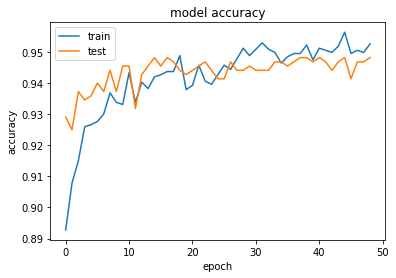

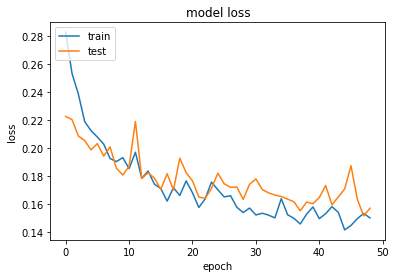

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'][1:])
plt.plot(history.history['val_accuracy'][1:])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### DUAL CHANNEL CNN WITHOUT AUGMENTATION

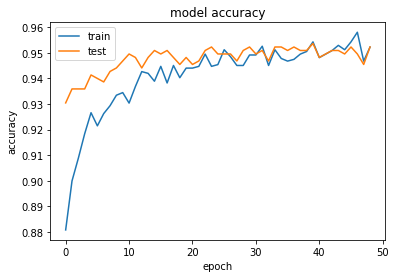

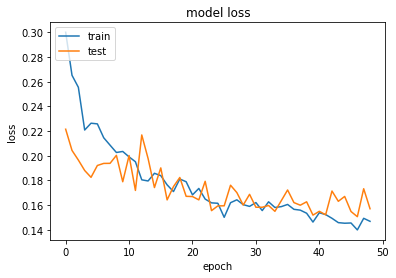

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'][1:])
plt.plot(history.history['val_accuracy'][1:])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## **MODEL PREDICTIONS**

In [ ]:
def generate_predictions(path):
  X_data = []
  files = glob.glob (path)
  for myFile in files:
    # print(myFile)
    image = cv2.imread (myFile)
    X_data.append (image)
  X_test_data_numeric = extract_features1(X_data)
  X_test_data_image = np.array(X_data)

  preds = model.predict([X_test_data_numeric, X_test_data_image])

  return preds

In [ ]:
y_preds1 = generate_predictions("/content/New_DR/test/DR/*.png")
y_preds2 = generate_predictions("/content/New_DR/test/No_DR/*.png")

y_pred = np.concatenate((y_preds1, y_preds2))
y_pred.shape

(733, 1)

In [ ]:
y_pred_new = np.where(y_pred>0.5,1,0)
y_pred_new.shape

(733, 1)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

print("Accuracy Score:", round(accuracy_score(y_test, y_pred_new[:,0])*100,2))
print("Confusion Matrix: \n",confusion_matrix(y_test, y_pred_new[:,0]))
print("Classification Report: \n",classification_report(y_test, y_pred_new[:,0]))


Accuracy Score: 95.23
Confusion Matrix: 
 [[350  11]
 [ 24 348]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.97      0.95       361
           1       0.97      0.94      0.95       372

    accuracy                           0.95       733
   macro avg       0.95      0.95      0.95       733
weighted avg       0.95      0.95      0.95       733



In [ ]:
# Saving Model 

model_json = model.to_json()
with open("DC-CNN-model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("DC-CNN-model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# load json and create model

json_file = open('DC-CNN-model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("DC-CNN-model.h5")
print("Loaded model from disk")

## **OTHER MODELS FOR COMPARISON**

## 1) INCEPTION

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(base_model.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

inc_model = tf.keras.models.Model(base_model.input, x)

inc_model.compile(optimizer = RMSprop(lr=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
tf.config.experimental_run_functions_eagerly(True)
inc_history = inc_model.fit(x=[X_train_image], y=y_train,
	                  validation_data=([X_test_image], y_test),
	                  epochs=50, batch_size=64, verbose=1, shuffle=True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


46/46 [==============================] - 37s 758ms/step - loss: 17.8872 - accuracy: 0.7327 - val_loss: 7.4055 - val_accuracy: 0.6385
Epoch 2/50
46/46 [==============================] - 30s 661ms/step - loss: 2.6051 - accuracy: 0.7883 - val_loss: 1.2121 - val_accuracy: 0.8513
Epoch 3/50
46/46 [==============================] - 30s 663ms/step - loss: 0.7189 - accuracy: 0.8283 - val_loss: 0.3174 - val_accuracy: 0.8936
Epoch 4/50
46/46 [==============================] - 31s 665ms/step - loss: 0.3324 - accuracy: 0.8815 - val_loss: 0.3803 - val_accuracy: 0.8690
Epoch 5/50
46/46 [==============================] - 31s 669ms/step - loss: 0.5437 - accuracy: 0.8593 - val_loss: 0.2899 - val_accuracy: 0.8963
Epoch 6/50
46/46 [==============================] - 31s 666ms/step - loss: 0.3548 - accuracy: 0.8778 - val_loss: 0.3223 - val_accuracy: 0.8745
Epoch 7/50
46/46 [==============================] - 31s 668ms/step - loss: 0.3481 - accuracy: 0.8887 - val_loss: 0.3221 - val_accuracy: 0.8990
Epoch 8/5

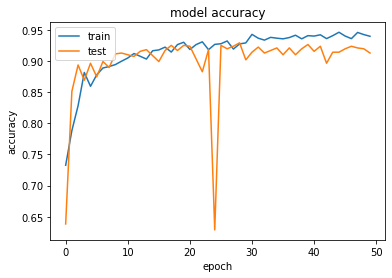

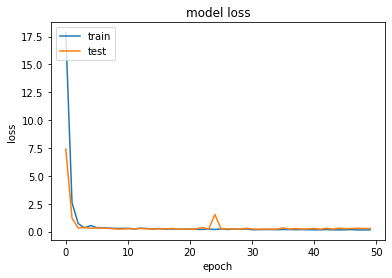

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(inc_history.history['accuracy'])
plt.plot(inc_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(inc_history.history['loss'])
plt.plot(inc_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred = inc_model.predict(X_test_image)
y_pred.shape

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


(733, 1)

In [ ]:
y_pred_new = np.where(y_pred>0.5,1,0)
y_pred_new.shape

(733, 1)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

print("Accuracy Score:", round(accuracy_score(y_test, y_pred_new[:,0])*100,2))
print("Confusion Matrix: \n",confusion_matrix(y_test, y_pred_new[:,0]))
print("Classification Report: \n",classification_report(y_test, y_pred_new[:,0]))

Accuracy Score: 91.27
Confusion Matrix: 
 [[321  40]
 [ 24 348]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.89      0.91       361
           1       0.90      0.94      0.92       372

    accuracy                           0.91       733
   macro avg       0.91      0.91      0.91       733
weighted avg       0.91      0.91      0.91       733



In [ ]:
# Saving Model 

model_json = inc_model.to_json()
with open("Inception-model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
inc_model.save_weights("Inception-model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# load json and create model

json_file = open('Inception-model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("Inception-model.h5")
print("Loaded model from disk")

## 2) RESNET 50

In [40]:
from tensorflow.keras.applications import ResNet50

res_model = ResNet50(input_shape=(224, 224,3), include_top=False, weights="imagenet")

94773248/94765736 [==============================] - 0s 0us/step


In [41]:
for layer in res_model.layers:
    layer.trainable = False

In [42]:
from tensorflow.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D

res_model = Sequential()
res_model.add(ResNet50(include_top=False, weights='imagenet', pooling='max'))
res_model.add(Dense(1, activation='sigmoid')) 

In [43]:
res_model.compile(optimizer = tf.keras.optimizers.SGD(lr=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [44]:
resnet_history = res_model.fit(x=[X_train_image], y=y_train,
	                  validation_data=([X_test_image], y_test),
	                  epochs=50, batch_size=32, verbose=1, shuffle=True)

Epoch 1/50
92/92 [==============================] - 41s 368ms/step - loss: 0.5943 - accuracy: 0.8522 - val_loss: 0.9149 - val_accuracy: 0.6999
Epoch 2/50
92/92 [==============================] - 31s 334ms/step - loss: 0.2911 - accuracy: 0.9194 - val_loss: 0.5532 - val_accuracy: 0.8540
Epoch 3/50
92/92 [==============================] - 30s 331ms/step - loss: 0.1763 - accuracy: 0.9403 - val_loss: 0.4006 - val_accuracy: 0.9031
Epoch 4/50
92/92 [==============================] - 31s 334ms/step - loss: 0.1382 - accuracy: 0.9536 - val_loss: 0.3613 - val_accuracy: 0.9236
Epoch 5/50
92/92 [==============================] - 31s 333ms/step - loss: 0.0879 - accuracy: 0.9689 - val_loss: 0.3574 - val_accuracy: 0.9181
Epoch 6/50
92/92 [==============================] - 31s 332ms/step - loss: 0.0643 - accuracy: 0.9761 - val_loss: 0.3413 - val_accuracy: 0.9168
Epoch 7/50
92/92 [==============================] - 31s 333ms/step - loss: 0.0543 - accuracy: 0.9792 - val_loss: 0.3405 - val_accuracy: 0.9263

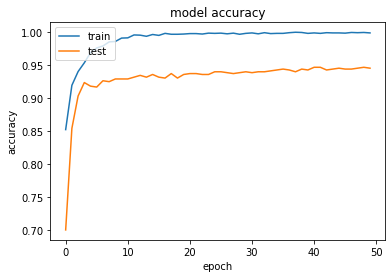

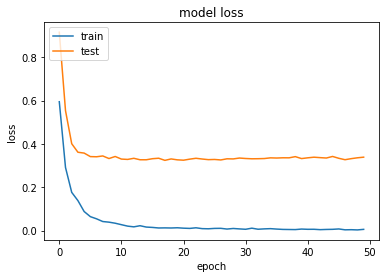

In [45]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(resnet_history.history['accuracy'])
plt.plot(resnet_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(resnet_history.history['loss'])
plt.plot(resnet_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [46]:
y_pred = res_model.predict(X_test_image)
y_pred.shape 

(733, 1)

In [47]:
y_pred_new = np.where(y_pred>0.5,1,0)
y_pred_new.shape

(733, 1)

In [48]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

print("Accuracy Score:", round(accuracy_score(y_test, y_pred_new[:,0])*100,2))
print("Confusion Matrix: \n",confusion_matrix(y_test, y_pred_new[:,0]))
print("Classification Report: \n",classification_report(y_test, y_pred_new[:,0]))

Accuracy Score: 94.54
Confusion Matrix: 
 [[347  14]
 [ 26 346]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.96      0.95       361
           1       0.96      0.93      0.95       372

    accuracy                           0.95       733
   macro avg       0.95      0.95      0.95       733
weighted avg       0.95      0.95      0.95       733



In [49]:
# Saving Model 

model_json = res_model.to_json()
with open("Resnet-model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
res_model.save_weights("Resnet-model.h5")
print("Saved model to disk")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Saved model to disk


In [ ]:
# load json and create model

json_file = open('Resnet-model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("Resnet-model.h5")
print("Loaded model from disk")